### Python module/package imports for this chapter

In [9]:
import os, sys, collections, itertools, re, json, io, base64

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as pp
import matplotlib.animation as anim
from mpl_toolkits.basemap import Basemap

%matplotlib inline

In [2]:
import requests
import bs4      # BeautifulSoup 4

In [3]:
import IPython.display
import PIL, PIL.Image, PIL.ImageOps, PIL.ImageEnhance  # Python Imaging Library - now "pillow"

### Code needed from previous video

In [4]:
def getday(day):
    """Load the webpage collecting Curiosity Front Hazard Cam
    images for Sol day, and yield a sequence of URLs for (left,right) pairs.
    Before loading, see if the webpage is available in a local cache."""
    
    cached = os.path.join('images',str(day) + '.html')
    try:
        text = open(cached,'r').read()
    except FileNotFoundError:
        daypage = requests.get('http://mars.nasa.gov/msl/multimedia/raw',
                               params={'s': day,'camera': 'FHAZ'})
        text = daypage.text
    
    soup = bs4.BeautifulSoup(text,'lxml')
    srcs = [img['src'] for img in soup.find_all('img') if 'Image' in img['alt']]
    
    # drop the smaller thumbnail duplicates
    srcs = srcs[:int(len(srcs)/2)]

    # modify URLs to high-resolution images
    srcs = [re.sub('-thm','',src) for src in srcs]
    
    print("Found {} images for day {}...".format(len(srcs),day))

    # iterate over nonoverlapping pairs in the list:
    # 0,2,4,... and 1,3,5,...
    for one, two in zip(srcs[::2],srcs[1::2]):
        # we may get the left/right in the wrong order, so check the URLs
        left, right = (one, two) if 'FLB' in one else (two, one)
        
        yield left, right

In [5]:
def getimage(url):
    """Load a Curiosity image from url, resize it and dewarp it.
    However, first see if the image is available in a local cache."""
    
    # big = re.sub('-thm','',url)

    cached = os.path.join('images',os.path.basename(url))
    try:
        content = open(cached,'rb').read()
    except FileNotFoundError:
        content = requests.get(url).content
    
    img = PIL.Image.open(io.BytesIO(content))
    
    resized = img.resize((400,400))
    dewarped = img.transform((400,300),
                             PIL.Image.QUAD,data=(0,0,100,400,300,400,400,0),
                             resample=0,fill=1)
    
    return dewarped

In [6]:
def blend(left,right):
    """Colorize and blend left and right Curiosity images."""
    
    blend = PIL.Image.blend(PIL.ImageOps.colorize(left,(0,0,0),(255,0,0)),
                            PIL.ImageOps.colorize(right,(0,0,0),(0,255,255)),0.5)
    
    enhanced = PIL.ImageEnhance.Brightness(blend)
    
    return enhanced.enhance(1.75)

## Making a stereoscopic movie and a Martian roll-through with `matplotlib`: ffmpeg version

In [7]:
!mkdir frames

Found 2 images for day 1350...
Found 10 images for day 1351...
Found 6 images for day 1352...
Found 4 images for day 1353...
Found 2 images for day 1354...
Found 8 images for day 1355...
Found 4 images for day 1356...
Found 4 images for day 1357...
Found 10 images for day 1358...
Found 12 images for day 1359...
Found 6 images for day 1360...
Found 56 images for day 1361...
Found 2 images for day 1362...
Found 2 images for day 1363...
Found 2 images for day 1364...
Found 4 images for day 1365...
Found 10 images for day 1366...
Found 2 images for day 1367...
Found 6 images for day 1368...
Found 6 images for day 1369...
Found 2 images for day 1370...
Found 4 images for day 1371...
Found 2 images for day 1372...
Found 4 images for day 1373...
Found 2 images for day 1374...
Found 4 images for day 1375...
Found 6 images for day 1376...
Found 2 images for day 1377...
Found 4 images for day 1378...
Found 2 images for day 1379...
Found 8 images for day 1380...
Found 4 images for day 1381...
Fou

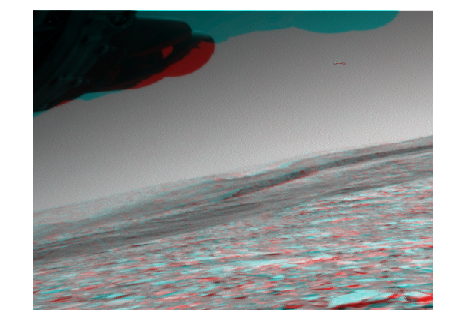

In [10]:
fig = pp.figure(figsize=(400/72,300/72),dpi=72)

axes = pp.Axes(fig,[0,0,1,1])
axes.set_axis_off()
fig.add_axes(axes)

# iterator for filename with ever-increasing index
filename = ('frames/{:04d}.png'.format(i) for i in itertools.count(start=0,step=1))
 
for day in range(1350,1399):
    for left,right in getday(day):
        frame = blend(getimage(left),getimage(right))
        pp.imshow(frame,interpolation='none')
        pp.savefig(next(filename),dpi=72)

In [ ]:
!ffmpeg -framerate 5 -i frames/%04d.png -c:v libx264 -r 5 -pix_fmt yuv420p mars-ffmpeg.mp4